#### Load necessary packages

In [1]:
import os
import sys
sys.path.insert(0,'../../mocsy')

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm
import pickle 
import random
import matplotlib.pyplot as plt
from scipy import stats

import mocsy
from mocsy import mvars
from mocsy import mrhoinsitu
from mocsy import mrho

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Training data

#### Read in the observational data

In [4]:
print("for tos, use the ESA CCI and C3S product until October 2022, then Armor3D for November and December")
print("for siconc, use the ESA CCI and C3S product until October 2022, then METOFFICE Ostia for November and December")
print("for chlos, use the climatological mean value before September 1997")
print("for co2, use a global representative value, given by the annual average measurement from Manua Loa, Hawaii")
ds_cci = xr.open_dataset("../data/ESACCI_and_C3S-GLO-SST-L4-REP-OBS-SST_multi-vars_1x1grid_1982-01-01-2022-10-31_monmean.nc"
                    ).sel(time=slice('1993-01-01', '2022-10-31'))
ds_ostia = xr.open_dataset("../data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_multi-vars_1x1grid_2022-11-01-2022-12-31_monmean.nc")
ds_armor = xr.open_dataset("../data/dataset-armor-3d-rep-monthly_multi-vars_1x1grid_coarsened_0.00m_1993-01-01-2022-12-01.nc")
ds_ssh = xr.open_dataset(
     "../data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_adt_1x1grid_coarsened_1993-01-01-2022-12-31_monmean.nc")
ds_globcol = xr.open_dataset("../data/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_1x1grid_1997-09-01-2022-12-01.nc")
ds_globcol_clim = xr.open_dataset(
    "../data/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_1x1grid_1997-09-01-2022-12-01_ymonmean.nc")

df_co2 = pd.read_csv("../data/monthly_in_situ_co2_mlo_no_header.csv")
ds_era5 = xr.open_dataset("../data/era5_winds_1993_2022_1x1grid.nc")
ds_socat = xr.open_dataset("../data/SOCATv2023_tracks_gridded_monthly.nc").sel(tmnth=slice('1993-01-01', '2022-12-31'))

seamask = xr.open_dataset("../data/RECCAP2_region_masks_all_v20221025.nc").seamask
seamask_rolled = np.repeat(np.roll(seamask.values, shift=-180, axis=1)[np.newaxis, :, :], 360, axis=0)

for tos, use the ESA CCI and C3S product until October 2022, then Armor3D for November and December
for siconc, use the ESA CCI and C3S product until October 2022, then METOFFICE Ostia for November and December
for chlos, use the climatological mean value before September 1997
for co2, use a global representative value, given by the annual average measurement from Manua Loa, Hawaii


In [5]:
data = {}

data["tos"] = np.concatenate([ds_cci.analysed_sst.values - 273.15, # ESA CCI and C3S is in Kelvin units
                      ds_armor.to.squeeze().values[-2:, :, :]], axis=0)

data["tos"][seamask_rolled == 0] = np.nan

data["siconc"] = np.concatenate([ds_cci.sea_ice_fraction.values,
                         ds_ostia.sea_ice_fraction.values], axis=0) * 100
# to have concentration in range 0 100, as in models
data["siconc"][seamask_rolled == 0] = np.nan


data["sos"] = ds_armor.so.squeeze().values
#Remove samples with sos < 10, since these were also removed during training of CMIP6 base model"
data["sos"][data["sos"] < 10] = np.nan
data["sos"][seamask_rolled == 0] = np.nan

data["mlotst"] = ds_armor.mlotst.squeeze().values
data["mlotst"][seamask_rolled == 0] = np.nan

data["zos"] = ds_ssh.adt.squeeze().values
data["zos"][seamask_rolled == 0] = np.nan

data["chlos"] = np.concatenate([np.concatenate([ds_globcol_clim.CHL.values for i in range(5)],
                                                  axis=0)[:-4, :, :], ds_globcol.CHL.values], axis=0) * 1e-6
# to go from mg m-3 to kg m-3 
#data["chlos"][np.logical_and(np.isnan(data["chlos"]), np.isfinite(data["tos"]))] = 0
data["chlos"][seamask_rolled == 0] = np.nan

df_co2_yearmean = df_co2[['  Yr', '     CO2']].groupby('  Yr').mean()
co2_scalar = df_co2_yearmean.loc[1993:2022]['     CO2'].values
data["co2"] = np.concatenate([co2_year * np.ones((12, 180, 360)) for co2_year in co2_scalar], axis=0)

data["uas"] = ds_era5.u10.values
data["vas"] = ds_era5.v10.values

data["fco2"] = ds_socat.fco2_ave_weighted.values

In [6]:
data["lat"] = np.repeat(np.repeat(np.arange(-89.5, 90)[np.newaxis, :],
                         360, axis=0)[:, :, np.newaxis], 360, axis=2)

data["lon"] = np.repeat(np.repeat(np.arange(-179.5, 180)[np.newaxis, :],
                         180, axis=0)[np.newaxis, :, :], 360, axis=0)
data["mon"] = np.repeat(np.repeat(np.array([i % 12 for i in range(360)])[:, np.newaxis],
                          180, axis=1)[:, :, np.newaxis], 360, axis=2)

In [7]:
predictors = ["tos", "siconc", "sos", "mlotst", "zos", "chlos", "co2",
              "uas", "vas", "lat", "lon", "mon"]
for predictor in predictors:
    print("Number of non-nan grid cells for {}: {}". format(
        predictor, np.sum(np.isfinite(data[predictor]))
    ))

Number of non-nan grid cells for tos: 15058446
Number of non-nan grid cells for siconc: 15058440
Number of non-nan grid cells for sos: 15053204
Number of non-nan grid cells for mlotst: 14983581
Number of non-nan grid cells for zos: 13209876
Number of non-nan grid cells for chlos: 12450247
Number of non-nan grid cells for co2: 23328000
Number of non-nan grid cells for uas: 23328000
Number of non-nan grid cells for vas: 23328000
Number of non-nan grid cells for lat: 23328000
Number of non-nan grid cells for lon: 23328000
Number of non-nan grid cells for mon: 23328000


In [8]:
for predictor in predictors:
    print("Minimum and maximum for {}: {:.2e}, {:.2e}". format(
        predictor, np.nanmin(data[predictor]), np.nanmax(data[predictor])
    ))

Minimum and maximum for tos: -2.11e+00, 3.31e+01
Minimum and maximum for siconc: 0.00e+00, 1.00e+02
Minimum and maximum for sos: 1.00e+01, 3.98e+01
Minimum and maximum for mlotst: 1.01e+01, 2.14e+03
Minimum and maximum for zos: -1.57e+00, 2.20e+00
Minimum and maximum for chlos: 1.06e-08, 4.94e-05
Minimum and maximum for co2: 3.57e+02, 4.18e+02
Minimum and maximum for uas: -1.75e+01, 1.42e+01
Minimum and maximum for vas: -1.58e+01, 2.01e+01
Minimum and maximum for lat: -8.95e+01, 8.95e+01
Minimum and maximum for lon: -1.80e+02, 1.80e+02
Minimum and maximum for mon: 0.00e+00, 1.10e+01


In [9]:
print("Number of non-nan grid cells for fCO2: {}". format(
    np.sum(np.isfinite(data["fco2"]))
    ))

Number of non-nan grid cells for fCO2: 341467


In [10]:
print("Minimum and maximum for fCO2: {:.2e}, {:.2e}". format(
    np.nanmin(data["fco2"]), np.nanmax(data["fco2"])
))

Minimum and maximum for fCO2: 4.45e+01, 4.31e+03


#### Creation of training data

In [11]:
print("Number of SOCAT samples: {}".format(np.sum(np.isfinite(data["fco2"]))))
# check how many grid cells have non-nan values in socat fco2 and all predictor fields
# (some predictors left out because they have no missing values)
is_socat_training_sample = np.isfinite(data["fco2"] * data["siconc"] * data["tos"] * data["sos"]
                                       * data["mlotst"] * data["zos"] * data["chlos"])
print("Number of SOCAT samples where all predictors available: {} ({:.1f} %)".format(
    np.sum(is_socat_training_sample),
    100 * np.sum(is_socat_training_sample) / np.sum(np.isfinite(data["fco2"]))))

data_socat = {}
for key in ["fco2"] + predictors:
    data_socat[key] = data[key][is_socat_training_sample]

Number of SOCAT samples: 341467
Number of SOCAT samples where all predictors available: 311440 (91.2 %)


# Preprocessing of data for training

#### Transform mon to mon_sin and mon_cos

In [12]:
data_socat["mon_sin"] = np.sin(data_socat["mon"] / 12 * 2 * np.pi)
data_socat["mon_cos"] = np.cos(data_socat["mon"] / 12 * 2 * np.pi)
del data_socat["mon"]

#### Transform lat and lon

Following Gade et al., 2010: A Non-singular Horizontal Position Representation

In [13]:
data_socat["nvector1"] = np.sin(data_socat["lat"] / 360 * 2 * np.pi)
data_socat["nvector2"] = np.sin(data_socat["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_socat["lat"] / 360 * 2 * np.pi)
data_socat["nvector3"] = - np.cos(data_socat["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_socat["lat"] / 360 * 2 * np.pi)
del data_socat["lon"]
del data_socat["lat"]

#### Log-transform mlotst and chlos

In [14]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

In [15]:
print("mlotst statistic: ",
      stats.kstest(normalize(data_socat["mlotst"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(data_socat["mlotst"])), stats.norm.cdf)[0])

mlotst statistic:  0.23653021181947087
mlotst statistic with log transform:  0.05216682639068482


In [16]:
print("mlotst statistic: ",
      stats.kstest(normalize(data_socat["chlos"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(data_socat["chlos"])), stats.norm.cdf)[0])

mlotst statistic:  0.28406905399619975
mlotst statistic with log transform:  0.04376417813484801


Text(0.5, 1.0, 'mlotst')

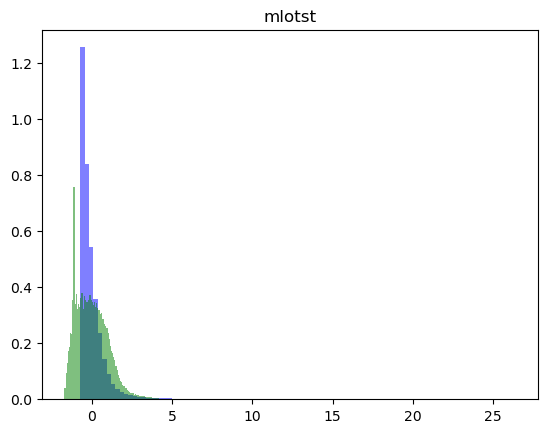

In [17]:
plt.hist(normalize(data_socat["mlotst"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["mlotst"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("mlotst")

Text(0.5, 1.0, 'chlos')

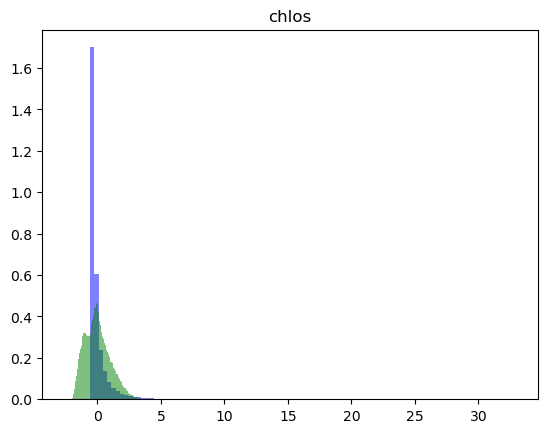

In [18]:
plt.hist(normalize(data_socat["chlos"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["chlos"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("chlos")

In [19]:
data_socat["mlotst"] = np.log(data_socat["mlotst"])
data_socat["chlos"] = np.log(data_socat["chlos"])

####  Split into training and validation sets

In [20]:
np.random.seed(0)
random.seed(0)
train_valid_split = 0.833 
# As before, have 5/6 as training and 1/6 as validation data
random_indices = np.arange(len(data_socat["tos"]), dtype=int)

random.shuffle(random_indices)

ntrain_socat = int(len(data_socat["tos"]) * train_valid_split)
train_socat = {key: data_socat[key][random_indices][:ntrain_socat]
               for key in data_socat}
valid_socat = {key: data_socat[key][random_indices][ntrain_socat:]
               for key in data_socat}

#### normalize data and convert into feature and label arrays

In [21]:
feature_keys = ["tos", "sos", "mlotst", "zos", "chlos", "siconc", "uas", "vas",
                "co2", "mon_sin", "mon_cos", "nvector1", "nvector2", "nvector3"]

with open('../data/cmip6_base_model_train_feature_means.pkl', 'rb') as f:
    train_feature_means = pickle.load(f)

with open('../data/cmip6_base_model_train_feature_stds.pkl', 'rb') as f:
    train_feature_stds = pickle.load(f)

# Processing the socat data
train_features = np.concatenate([(
    train_socat[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

valid_features = np.concatenate([(
    valid_socat[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

train_labels = train_socat["fco2"] # maybe add [:, np.newaxis]

valid_labels = valid_socat["fco2"] # maybe add [:, np.newaxis]

In [22]:
# add additional dictionaries train_TS and valid_TS that only contain T and S normalized
# for fCO2 surrogate model
# original feature means and stds used to train the fCO2 surrogate model:
alk_range = [1000e-6, 3000e-6]
dic_range = [1000e-6, 3000e-6]
tem_range = [-2, 35]
sal_range = [10, 50]
sil_range = [0, 134e-6]
phos_range = [0, 4e-6]

sample_means = {"talkos":(alk_range[0] + alk_range[1]) / 2,
                 "dissicos":dic_range[0] + (dic_range[1] - dic_range[0]) / 4,
                 "tos":(tem_range[0] + tem_range[1]) / 2,
                 "sos":(sal_range[0] + sal_range[1]) / 2,
                 "sios":(sil_range[0] + sil_range[1]) / 2,
                 "po4os":(phos_range[0] + phos_range[1]) / 2}

sample_stds = {"talkos":(alk_range[1] - alk_range[0]) / np.sqrt(12),
                 "dissicos":(dic_range[1] - dic_range[0]) * np.sqrt(7 / 144),
                 "tos":(tem_range[1] - tem_range[0]) / np.sqrt(12),
                 "sos":(sal_range[1] - sal_range[0]) / np.sqrt(12),
                 "sios":(sil_range[1] - sil_range[0]) / np.sqrt(12),
                 "po4os":(phos_range[1] - phos_range[0]) / np.sqrt(12)}

train_TS = np.concatenate([
    (train_socat[key][:, np.newaxis] - sample_means[key]) / sample_stds[key]
    for key in ["tos", "sos"]
], axis=1)

valid_TS = np.concatenate([
    (valid_socat[key][:, np.newaxis] - sample_means[key]) / sample_stds[key]
    for key in ["tos", "sos"]
], axis=1)

In [23]:
print(np.mean(train_TS[:, 0]))
print(np.std(train_TS[:, 0]))
print(np.mean(train_TS[:, 1]))
print(np.std(train_TS[:, 1]))

0.11519687
0.88625634
0.393595
0.14267851


In [24]:
train_TS.shape

(259429, 2)

In [25]:
print("Check shapes of matrices.")
print(train_features.shape)
print(valid_features.shape)
print(train_labels.shape)
print(valid_labels.shape)

Check shapes of matrices.
(259429, 14)
(52011, 14)
(259429,)
(52011,)


In [26]:
print("Check normalization of features.")
print(np.mean(train_features, axis=0))
print(np.std(train_features, axis=0))
print(np.mean(valid_features, axis=0))
print(np.std(valid_features, axis=0))

Check normalization of features.
[ 3.40560855e-01  3.48531556e-01 -9.46184650e-02  6.30598974e-01
  1.87071998e-01 -3.94728129e-01 -1.15504249e-01 -4.51280958e-02
  3.17606148e-01 -1.95872158e-03 -1.86036128e-04  4.23308728e-01
 -1.44181142e-01  1.55766360e-01]
[0.83185128 0.92694102 0.68830814 0.82069753 0.60662202 0.21201642
 0.71008068 0.75068412 0.87296172 0.99579639 1.0041817  0.84029448
 0.95653175 1.10424399]
[ 0.3425848   0.34866217 -0.09621113  0.62925169  0.18461686 -0.39475969
 -0.11843128 -0.05036622  0.31401465 -0.01106068  0.00364473  0.42440164
 -0.14668035  0.1534404 ]
[0.83524292 0.91849444 0.68686597 0.82155402 0.60588765 0.21119669
 0.71201155 0.74725421 0.87381942 0.99546276 1.00444983 0.83857895
 0.95900556 1.10387754]


# Define neural network and training procedure

In [27]:
class flexible_MLP(nn.Module):
    def __init__(self, input_size, hidden_size_part1, inner_output_size, hidden_size_part2):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_part1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_part1, hidden_size_part1, device=self.device)
        self.linear3 = nn.Linear(hidden_size_part1, hidden_size_part1, device=self.device)
        self.linear4 = nn.Linear(hidden_size_part1, inner_output_size, device=self.device)
        
        self.linear1_socat = nn.Linear(inner_output_size + 2, hidden_size_part2, device=self.device)
        self.linear2_socat = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear3_socat = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear4_socat = nn.Linear(hidden_size_part2, 1, device=self.device)
    
    def forward(self, x, TS_data=None, mode=None):
        """
        mode can be socat or None
        (for None, only the first part of the network is used)
        TS_data only needs to be provided if mode is socat
        """
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = self.linear4(x)
        if mode == "socat":
            x_p1 = x[:, :2]
            x_p2 = x[:, 2:]
            x = torch.cat((x_p1, TS_data, x_p2), dim=-1)
            x = F.elu(self.linear1_socat(x))
            x = F.elu(self.linear2_socat(x))
            x = F.elu(self.linear3_socat(x))
            x = F.elu(self.linear4_socat(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [28]:
model = flexible_MLP(14, 160, 4, 160)
print(model)

print("Update the base and socat subnets and freeze these layers")
base_state_dict = torch.load("../models/CMIP6_base_model_160x3_elu_10000epo.pth")
socat_state_dict = torch.load("../models/fCO2_model_160x3_elu_10000epo.pth")

with torch.no_grad(): # not sure whether interfers with autograd
    model.linear1.weight.copy_(base_state_dict["linear1.weight"])
    model.linear1.bias.copy_(base_state_dict["linear1.bias"])
    model.linear2.weight.copy_(base_state_dict["linear2.weight"])
    model.linear2.bias.copy_(base_state_dict["linear2.bias"])
    model.linear3.weight.copy_(base_state_dict["linear3.weight"])
    model.linear3.bias.copy_(base_state_dict["linear3.bias"])
    model.linear4.weight.copy_(base_state_dict["linear4.weight"])
    model.linear4.bias.copy_(base_state_dict["linear4.bias"])
    
    model.linear1_socat.weight.copy_(socat_state_dict["linear1.weight"])
    model.linear1_socat.bias.copy_(socat_state_dict["linear1.bias"])
    model.linear2_socat.weight.copy_(socat_state_dict["linear2.weight"])
    model.linear2_socat.bias.copy_(socat_state_dict["linear2.bias"])
    model.linear3_socat.weight.copy_(socat_state_dict["linear3.weight"])
    model.linear3_socat.bias.copy_(socat_state_dict["linear3.bias"])
    model.linear4_socat.weight.copy_(socat_state_dict["linear4.weight"])
    model.linear4_socat.bias.copy_(socat_state_dict["linear4.bias"])

model.linear1_socat.weight.requires_grad = False
model.linear1_socat.bias.requires_grad = False
model.linear2_socat.weight.requires_grad = False
model.linear2_socat.bias.requires_grad = False
model.linear3_socat.weight.requires_grad = False
model.linear3_socat.bias.requires_grad = False
model.linear4_socat.weight.requires_grad = False
model.linear4_socat.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

flexible_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=4, bias=True)
  (linear1_socat): Linear(in_features=6, out_features=160, bias=True)
  (linear2_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear3_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear4_socat): Linear(in_features=160, out_features=1, bias=True)
)
Update the base and socat subnets and freeze these layers
Number of trainable parameters in the model: 54564


In [29]:
def training_dataloader(features, labels, batch_size, TS=None):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    if TS is None:
        batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                      for ind in batch_indices]
    elif TS is not None:
        batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(TS, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                      for ind in batch_indices]
    return batch_data

In [30]:
loss_function = nn.MSELoss()

In [31]:
def train_one_epoch(optimizer):
    running_loss = 0. # running loss over all batches in the epoch

    training_data = training_dataloader(train_features,
                                        train_labels,
                                        batch_size, train_TS)
    
    for batch in training_data:
        features, labels, TS = batch
        optimizer.zero_grad()
        outputs = torch.squeeze(model(features, TS, 'socat'))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().cpu().item()

    ntrain = len(train_labels)
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [32]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, n_epochs, optimizer, scheduler):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    
    for epoch in pbar:

        model.train()

        train_loss_epoch = train_one_epoch(optimizer)

        model.eval()
        with torch.no_grad():
            valid_outputs = torch.squeeze(model(
                torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
                torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda")),
                "socat"))
            valid_loss_epoch = loss_function(
                valid_outputs, torch.from_numpy(valid_labels).to(torch.device("cuda"))
                                        ).detach().cpu().item()
                
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss': f'{train_loss_epoch:.3e}',
                          'valid_loss': f'{valid_loss_epoch:.3e}',
                          'learn_rate': f'{lr:.3e}'}
                        )

    return train_stats

# Test zero-shot inference with pretrained base model

Mostly to test whether the order of magnitude of the output fits.

**On socat validation data**

In [33]:
def MSE(x, y):
    return np.sum((x - y)**2, axis=0) / len(x)

In [34]:
model.eval()
with torch.no_grad():
    model_output_zero_shot = model(
        torch.from_numpy(valid_features.astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS.astype("float32")).to(torch.device("cuda")),
        'socat').detach().cpu().numpy().squeeze()

In [35]:
print("RMSE: ", np.sqrt(MSE(valid_labels, model_output_zero_shot)))
print("Maximum absolute deviation: ", np.max(np.abs(model_output_zero_shot-valid_labels)))
print("99.9th percentile of absolute deviation (1000 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels), q=99.9))
print("99.99th percentile of absolute deviation (100 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels), q=99.99))
print("99.999th percentile of absolute deviation (10 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels), q=99.999))
print("Fraction of variance unexplained: ", MSE(valid_labels, model_output_zero_shot) / np.var(valid_labels))

RMSE:  35.323779998594304
Maximum absolute deviation:  703.66895
99.9th percentile of absolute deviation (1000 val's larger):  212.00233032226717
99.99th percentile of absolute deviation (100 val's larger):  335.67839294428074
99.999th percentile of absolute deviation (10 val's larger):  611.1845372922052
Fraction of variance unexplained:  0.7287234934778457


In [36]:
print("A sample to get an idea about how bad the prediction is: ")
print(model_output_zero_shot[:10])
print(valid_labels[:10])

A sample to get an idea about how bad the prediction is: 
[379.54492 423.44247 424.6518  338.3021  484.44296 370.76282 385.3887
 441.07864 403.83005 331.71848]
[341.0479  418.3272  413.92365 323.39258 461.78156 345.88348 357.98672
 417.60822 386.63385 323.4706 ]


# Training

#### Freeze all layers of the base model despite the last linear projection layer and train it

In [37]:
model.linear1.weight.requires_grad = False
model.linear1.bias.requires_grad = False
model.linear2.weight.requires_grad = False
model.linear2.bias.requires_grad = False
model.linear3.weight.requires_grad = False
model.linear3.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 644


In [38]:
batch_size = 1000
n_epochs = 2_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 2000)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:46<00:00,  3.41it/s, epoch=2000/2000, train_loss=7.118e+02, valid_loss=6.596e+02, learn_rate=1.001e-04]


#### Also unfreeze the second-last layer and retrain also that on a small learning rate

In [39]:
model.linear3.weight.requires_grad = True
model.linear3.bias.requires_grad = True

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 26404


In [40]:
batch_size = 1000
n_epochs = 4_000

base_learning_rate = 1e-4
gamma = calc_gammar(0.1, 4000) # 1 for no learning rate decay

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [21:13<00:00,  3.14it/s, epoch=4000/4000, train_loss=2.237e+02, valid_loss=3.501e+02, learn_rate=1.001e-05]


In [41]:
np.min(train_stats["valid_loss"])

329.22381591796875

#### Test with unfreezing the remaining model and retrain with an even smaller learning rate

In [42]:
model.linear1.weight.requires_grad = True
model.linear1.bias.requires_grad = True
model.linear2.weight.requires_grad = True
model.linear2.bias.requires_grad = True

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 54564


In [43]:
batch_size = 1000
n_epochs = 8_000

base_learning_rate = 1e-4
gamma = calc_gammar(0.1, 8000)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                             gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [46:26<00:00,  2.87it/s, epoch=8000/8000, train_loss=1.353e+02, valid_loss=3.360e+02, learn_rate=1.000e-05]


#### Other option: fully retrain the base network (no transfer learning case)

In [44]:
model = flexible_MLP(14, 160, 4, 160)
print(model)

with torch.no_grad(): # not sure whether interfers with autograd
    model.linear1_socat.weight.copy_(socat_state_dict["linear1.weight"])
    model.linear1_socat.bias.copy_(socat_state_dict["linear1.bias"])
    model.linear2_socat.weight.copy_(socat_state_dict["linear2.weight"])
    model.linear2_socat.bias.copy_(socat_state_dict["linear2.bias"])
    model.linear3_socat.weight.copy_(socat_state_dict["linear3.weight"])
    model.linear3_socat.bias.copy_(socat_state_dict["linear3.bias"])
    model.linear4_socat.weight.copy_(socat_state_dict["linear4.weight"])
    model.linear4_socat.bias.copy_(socat_state_dict["linear4.bias"])

model.linear1_socat.weight.requires_grad = False
model.linear1_socat.bias.requires_grad = False
model.linear2_socat.weight.requires_grad = False
model.linear2_socat.bias.requires_grad = False
model.linear3_socat.weight.requires_grad = False
model.linear3_socat.bias.requires_grad = False
model.linear4_socat.weight.requires_grad = False
model.linear4_socat.bias.requires_grad = False

flexible_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=4, bias=True)
  (linear1_socat): Linear(in_features=6, out_features=160, bias=True)
  (linear2_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear3_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear4_socat): Linear(in_features=160, out_features=1, bias=True)
)


In [45]:
batch_size = 1000
n_epochs = 10_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

train_stats_full_retrain = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [56:49<00:00,  2.93it/s, epoch=10000/10000, train_loss=8.476e+01, valid_loss=3.064e+02, learn_rate=1.000e-05]


In [48]:
np.min(train_stats_full_retrain["valid_loss"])

271.70098876953125

In [46]:
np.where(train_stats_full_retrain["valid_loss"] == np.min(train_stats_full_retrain["valid_loss"]))

(array([1751]),)

Text(0, 0.5, 'Mean squared error')

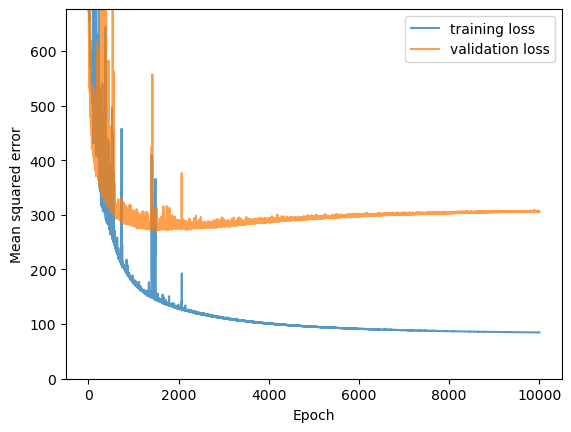

In [47]:
plt.plot(train_stats_full_retrain["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats_full_retrain["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([0, train_stats["train_loss"][-1] * 5])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")